# Deterministic scale-free hierarchical network

In this example, we use Dlink to find the communities in a scale-free hierarchical deterministic graph created using the model from [Ravasz E. & Barabasi A.](https://link.aps.org/doi/10.1103/PhysRevE.67.026112)

**Warning:** The model creates undirected graphs; however, Dlink, currently, is designed to work in directed graphs. We believe that undirected graphs can be implemented into the software, but we have yet to run further analysis to verify this statement. In this example, the results "seem" to go along with our intuition, but, for the moment, take these results in good faith.

## Introduction

Scale-free graphs are interesting because the degree distribution of those graphs follows a power law.

$$
  P(k) \sim  k^{-\gamma}
$$

In which $\gamma\in(2, 3)$ and $k$ is the degree of a node. If a network is scale-free, the variance of its degree distribution diverges. This phenomenon implies that it is possible to find nodes with a shallow and very high degree. To understand what this means, imagine the universe. In the universe, you can have solar systems in which some planets orbit a start. If you increase the scale, you can find galaxies where starts start orbiting the center of the galaxy, which is sometimes a black hole. If you increase your scale, you can have galaxy clusters closer to other galaxy clusters and separated by space. Closer clusters in the universe for superclusters, and so on. The idea is that there is no preferred or universal scale to investigate the system. 
The further up or further in you get, you will "see" similar structures resulting from the agglomeration of structures in lower scales. In a scale-free network, you need to know at which level of network you are. You can be in a branch of the network or look at the whole system, which will look similar. What connects different levels of the network are the nodes with the highest degree, or "hubs." Nodes belonging to subsystems will have a small degree, but they will be connected to similar subsystems by the hubs, which explicitly have a higher degree.

The absence of a scale in nature is not unique to the planets, stars, or galaxies but happens in several other systems such as biological and social networks, the World Wide Web, etc. If scale-free networks are common, understanding their properties can help us understand global features applied to many other systems. Another prevalent structure that constantly appears in nature is the presence of hierarchies. Hierarchies appear naturally to split a heterogeneous system into more homogeneous subsystems. This property is desired since it gives resilience to the whole network to changes or damages, so if the network is attacked, it will not collapse but remain stable.

As shown by [Dorogovtsev S. N., Goltsev A. V. & Mendes J. F. F](https://doi-org.proxy.library.nd.edu/10.1103/PhysRevE.65.066122), the clustering coefficient as a function of the degree $k$ in a deterministic scale-free networks is

$$
    C(k)\sim k^{-1}
$$

[Ravasz E. & Barabasi A.](https://link.aps.org/doi/10.1103/PhysRevE.67.026112) proposed a model for a deterministic scale-free hierarchical network in which its clustering coefficient and degree distribution follow Eq. $(1)$ and Eq. $(2)$. They also showed how several real-world networks share scale-free topology and clustering.

## Methods

We used the model proposed above to create a deterministic scale-free hierarchical undirected graph to investigate its properties using Dlink. For that purpose, let's load some libraries and create the HSF class. This class uses an undirected edge list as an initial network to create hierarchical replicas. This initial graph has a center that we call $A_{00}$, which connects with the rest of the nodes in the graph. At each level $l\in[1, L+1]$, the system is copied $N$ times. All nodes not $A_{00}$ get a connection to $A_{00}$ from the copies.


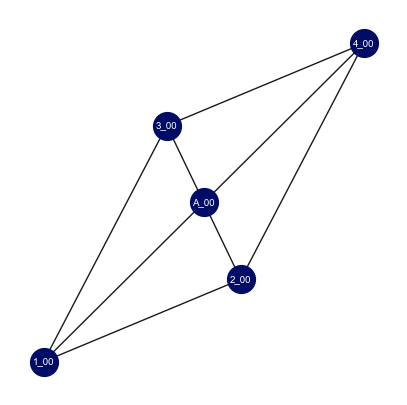

In [1]:
T = True
F = False
# Stadard python libs ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import networkx as nx
# Personal libs ----
from networks.toy import TOY
from modules.hierarmerge import Hierarchy
from modules.hierarentropy import Hierarchical_Entropy
from modules.colregion import colregion
from plotting_jupyter.plotting_H import Plot_H
from various.network_tools import get_best_kr, get_labels_from_Z, adj2df, match, get_best_kr_equivalence

# Initial graph ----
A = np.array(
  [
    [0, 1, 1, 1, 1],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 0, 1, 1, 0]
  ], dtype=float
)

# Plot seed graph ----
fig, ax = plt.subplots(1, 1)
G = nx.Graph(A)
pos = nx.spectral_layout(G)
nx.draw(
  G, pos=pos, ax=ax,
  node_size=400,
  node_color="#000C66",
  labels = {
    0 : "A_00",
    1 : "1_00",
    2 : "2_00",
    3 : "3_00",
    4 : "4_00"
  },
  font_size=7,
  font_color="white"
)
fig.set_figheight(5)
fig.set_figwidth(5)


In [2]:
def append_letter(list_, letter):
  list_ = [f"{s}_{letter}" for s in list_]
  return list_

# Get a edgelist from A
seed = adj2df(A)
seed = seed.loc[seed.source < seed.target]
seed = seed.loc[seed.weight != 0]
seed.source = seed.source.to_numpy().astype(str)
seed.target = seed.target.to_numpy().astype(str)
seed.source = append_letter(seed.source, "00")
seed.target = append_letter(seed.target, "00")
# Set the name of the central node to A_00
seed.source[seed.source == "0_00"] = "A_00"
seed.target[seed.target == "0_00"] = "A_00"

# Class to create the deterministic scale-free hierarchical networks ----
class HSF:
  def __init__(self, edgelist, central_node, N : int, L : int) -> None:
    self.edgelist = edgelist
    self.central = central_node
    self.N = N
    self.L = L
    self.edgelist = self.H_edgelist()
    self.A_matrix()

  def H_edgelist(self):
    EDGELIST = self.edgelist.copy()
    for l in np.arange(1, self.L + 1):
      ED = pd.DataFrame()
      for n in np.arange(self.N):
        ed = EDGELIST.copy()
        ed.source = append_letter(ed.source, f"{l}{n}")
        ed.target = append_letter(ed.target, f"{l}{n}")
        ED = pd.concat([ED, ed], ignore_index=T)
      ED = pd.concat([ED, self.add_edges2center(ED)], ignore_index=T)
      EDGELIST = pd.concat([ED, EDGELIST], ignore_index=T)
    return EDGELIST

  def A_matrix(self):
    nodes = np.unique(list(self.edgelist.source) + list(self.edgelist.target))
    nodes = np.sort(nodes)
    self.edgelist.source = match(self.edgelist.source.to_numpy(), nodes)
    self.edgelist.target = match(self.edgelist.target.to_numpy(), nodes)
    self.nodes = len(nodes)
    self.labels = nodes
    self.A = np.zeros((self.nodes, self.nodes))
    self.A[self.edgelist.source, self.edgelist.target] = 1
    self.A = self.A + self.A.T   
  
  def add_edges2center(self, ed : pd.DataFrame):
    added_nodes = np.unique(
      list(ed.source) + list(ed.target)
    )
    added_nodes = [n for n in added_nodes if self.central not in n]
    toCenter = pd.DataFrame(
      {
        "source" : added_nodes,
        "target" : [self.central] * len(added_nodes),
        "weight" : [1] * len(added_nodes)
      }
    )
    return toCenter

  def swaps(self):
    g = nx.Graph(self.A)
    g = nx.double_edge_swap(g, nswap=10000)
    self.A = nx.adjacency_matrix(g).todense()

Now, the network is created and processed using as usual the TOY & Hierarchy classes. Notice that we use the "bsim" similarity score. Since the matrix is very sparse, using the links and the non-links of the nodes may improve que quality in the similarity index. 

In [3]:
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = F
mode = "ZERO"
topology = "MIX"
mapping="trivial"
index = "D1_2_4"
discovery = "discovery_6"
opt_score = ["_S", "_D"]

properties = {
  "structure" : "HSF",
  "nlog10" : nlog10,
  "lookup" : lookup,
  "prob" : prob,
  "cut" : cut,
  "topology" : topology,
  "mapping" : mapping,
  "index" : index,
  "mode" : mode,
}

# Create toy & permute adjacency matrix ----
toy = HSF(seed, "A_00", 4, 2)
perm = np.random.permutation(np.arange(toy.nodes))
# Note, permutations can change the output of the algorithm
# if using cut=True
toy.A = toy.A[perm, :][:, perm]
toy.labels = toy.labels[perm]
# Create the toy ----
NET = TOY(toy.A, linkage, **properties)
NET.set_labels(toy.labels)
labels_dict = dict()
for i in np.arange(toy.nodes): labels_dict[i] = toy.labels[i]
H = Hierarchy(
  NET, toy.A, toy.A, np.zeros(toy.A.shape),
  toy.nodes, linkage, mode, undirected=True
)
# Compute quality functions ----
H.BH_features_cpp_no_mu()
## Compute link entropy ----
H.link_entropy_cpp("short", cut=cut)
## Compute la arbre de merde ----
H.la_abre_a_merde_cpp(H.BH[0])
## Compute node entropy ----
H.node_entropy_cpp("short", cut=cut)
## Set labels to network ----
L = colregion(NET, labels=NET.labels)
L.get_regions()
H.set_colregion(L)
# Entropy ----
HS = Hierarchical_Entropy(H.Z, H.nodes, list(range(H.nodes)))
HS.Z2dict("short")
H.entropy = [
  H.node_entropy, H.node_entropy_H,
  H.link_entropy, H.link_entropy_H
]

Compute link hierarchical agglomeration ----
Mu-free


/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Starting Z2dict

	link entropy :  Sh : 0.3380, and Sv : 0.6620


	link entropy H: Sh : 0.3301, and Sv : 0.6699

Compute node hierarchy ----
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 719
Commencer: la abre a merde
25%
50%
75%
Voila, bon ami
Starting Z2dict

	Node entropy :  Sh : 0.2933, and Sv : 0.7067


	Node entropy H: Sh : 0.2605, and Sv : 0.7395

Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 249


Visualize Entropy iterations!!!
Levels node hierarchy: 29
Levels link hierarchy: 46
            S dir                 c  level
79   0.037039   H  node_hierarchy_H      8
110  0.080780   V  node_hierarchy_H      6
21   0.039649   H    node_hierarchy      8
49   0.048665   V    node_hierarchy      9
219  0.023944   H  link_hierarchy_H     35
266  0.035964   V  link_hierarchy_H     34
126  0.022323   H    link_hierarchy     36
171  0.027741   V    link_hierarchy     37
Plot S iterations
Plot D iterations


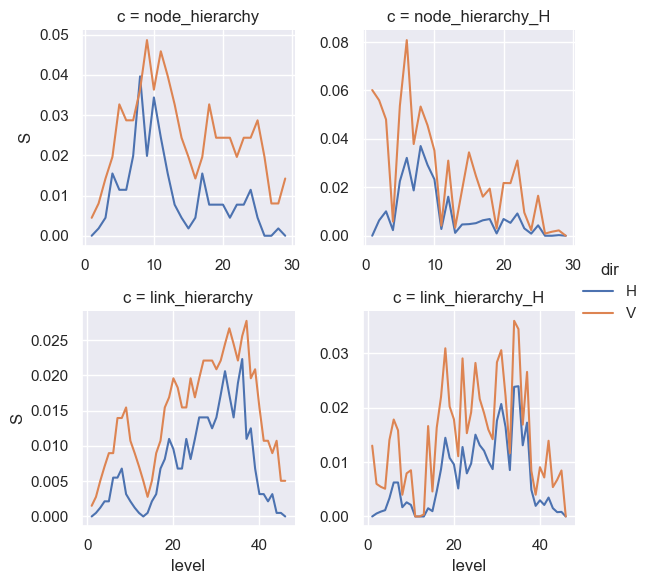

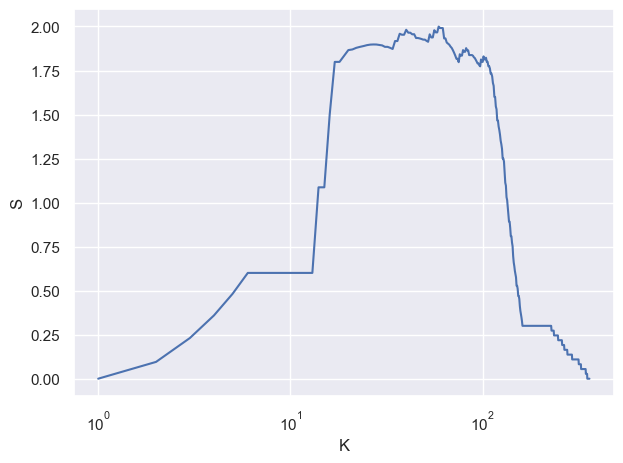

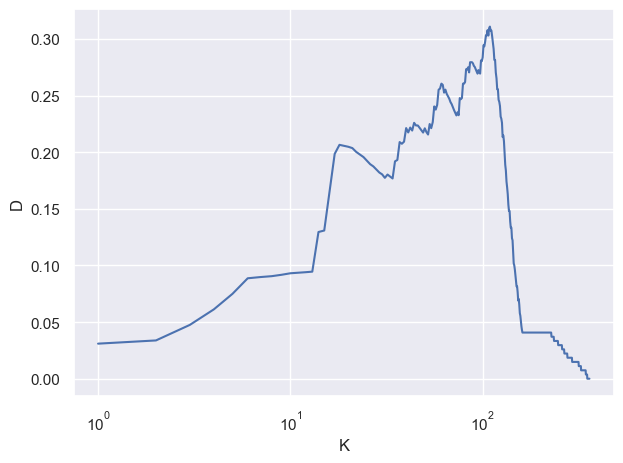

In [4]:
# Plot H ----
plot_h = Plot_H(NET, H)
plot_h.plot_measurements_Entropy()
plot_h.plot_measurements_S()
plot_h.plot_measurements_D()

In the case of the link partition entropy $S$:

/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/various/discovery_channel.py:262: RuntimeWarning: divide by zero encountered in divide
  Dsource = 1 / H.source_sim_matrix + 1
/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/various/discovery_channel.py:263: RuntimeWarning: divide by zero encountered in divide
  Dtarget = 1 / H.target_sim_matrix + 1


59 15
{'A_00_22': [6]}
Printing network space
Visualize pure LC memberships!!!
Visualize node-community dendrogram!!!


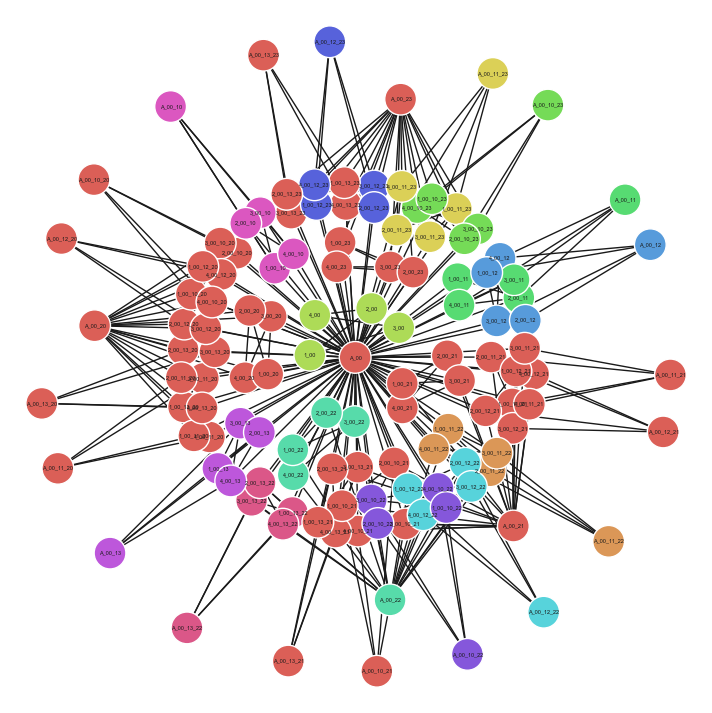

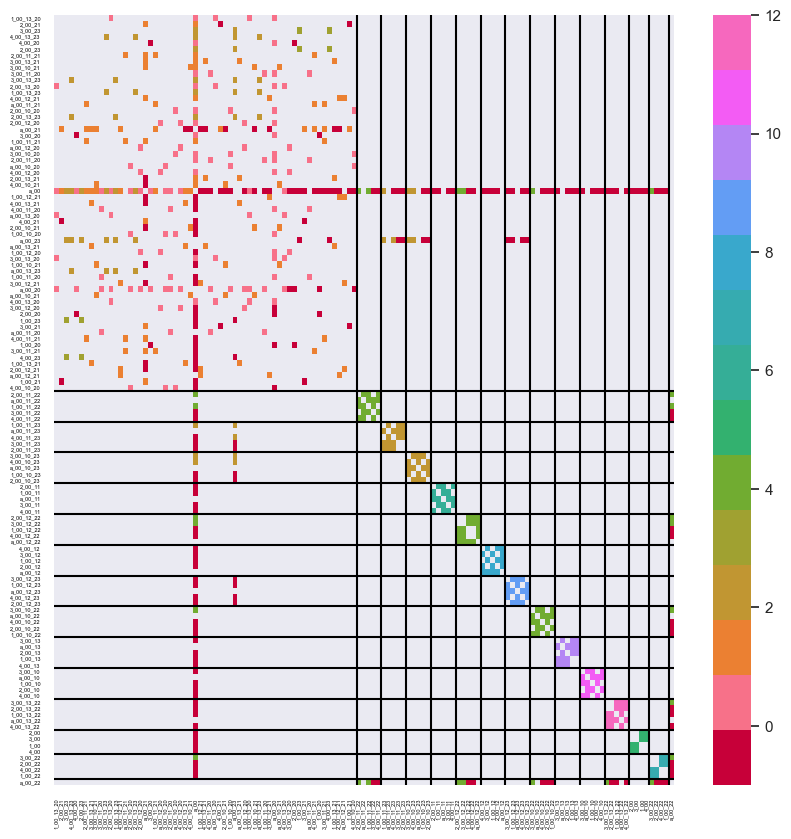

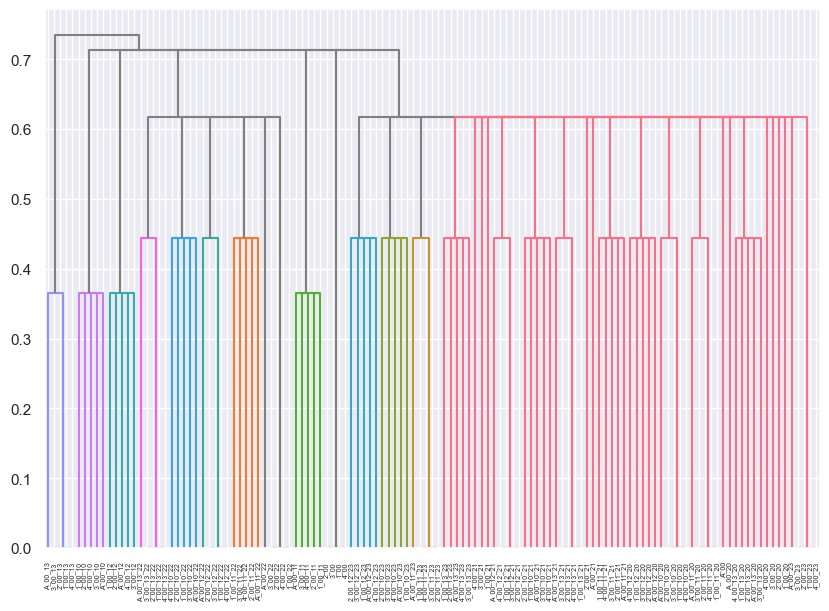

In [5]:
score = "_S"
K, R = get_best_kr_equivalence(score, H)
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]
rlabels = get_labels_from_Z(H.Z, r)
_, nocs_membership, sizes = H.discovery_channel[discovery](H, k, rlabels, undirected=T)
print(k, r)
print(nocs_membership)
plot_h.plot_network_kk(
  H, rlabels, nocs_membership, sizes, H.colregion.labels,
  ang=0, score=score, undirected=T, font_size=4
)
plot_h.lcmap_pure(
  [k], cmap_name="husl",
  labels = rlabels, font_size=4,
  figheight=10, figwidth=10, undirected=T
)
plot_h.core_dendrogram(
  [r], cmap_name="husl"
)

Now in the case of the average link partition density $D$:

/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/various/discovery_channel.py:262: RuntimeWarning: divide by zero encountered in divide
  Dsource = 1 / H.source_sim_matrix + 1
/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/various/discovery_channel.py:263: RuntimeWarning: divide by zero encountered in divide
  Dtarget = 1 / H.target_sim_matrix + 1
/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/various/discovery_channel.py:288: RuntimeWarning: Mean of empty slice
  Rc = np.nanmean(Dsn, axis=0)
/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/various/discovery_channel.py:298: RuntimeWarning: invalid value encountered in divide
  Rc = Rc + Rs / (len([i for i in range(len(NSC)) if np.linalg.norm(Dsn[i]) < max_m]))


109 36
{'A_00_21': [6, 7, 9, 19], 'A_00': [1, 5, 10, 11, 13, 17, 18], 'A_00_22': [2, 11, 12, 16, 22], 'A_00_23': [1], 'A_00_20': [0, 15, 20, 21]}
Printing network space
Visualize pure LC memberships!!!
Visualize node-community dendrogram!!!


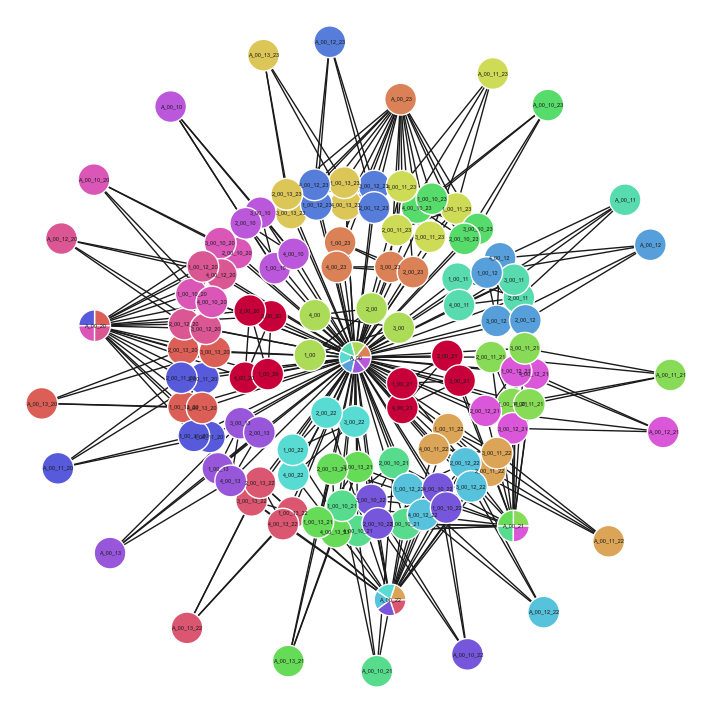

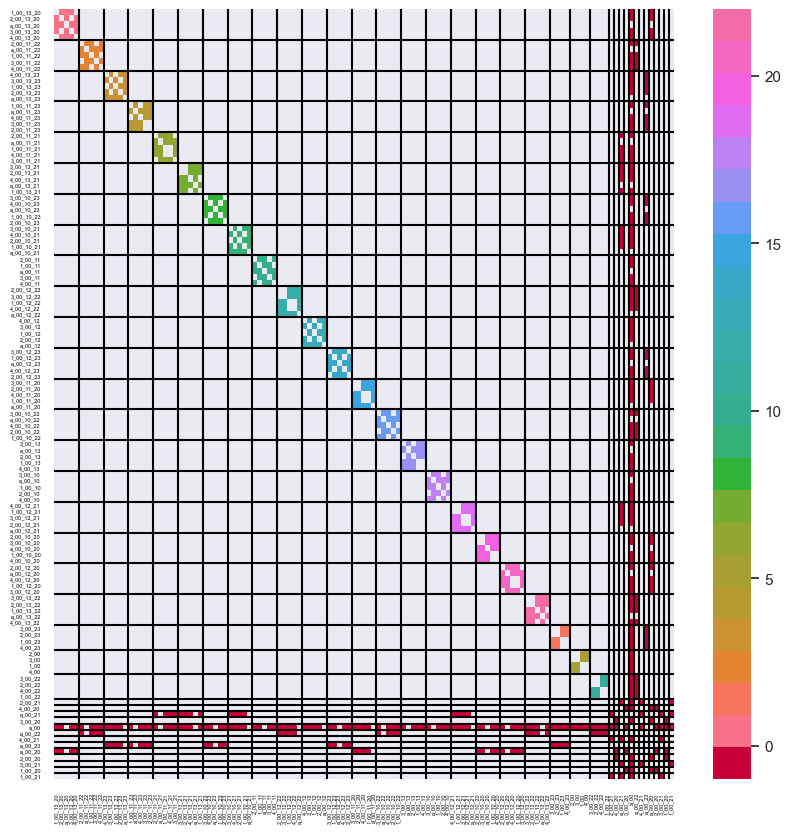

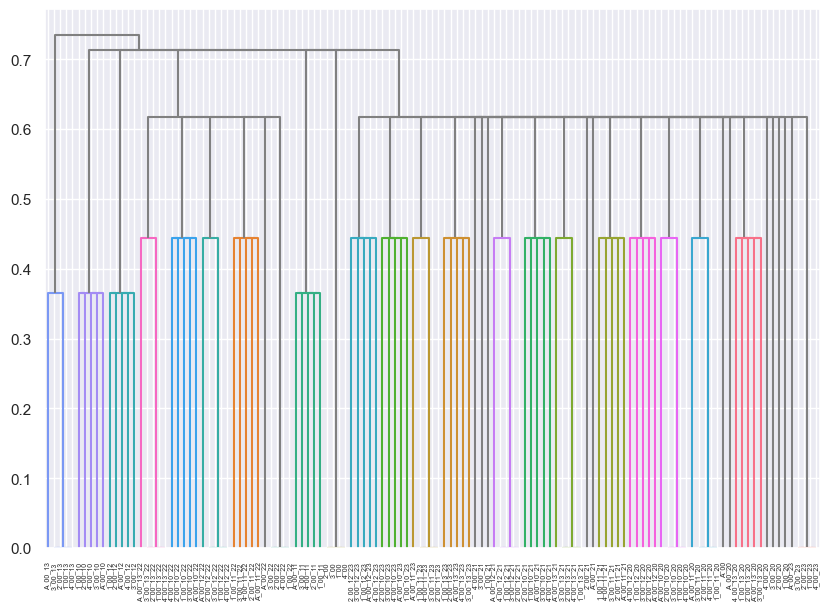

In [6]:
score = "_D"
K, R = get_best_kr_equivalence(score, H)
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]
rlabels = get_labels_from_Z(H.Z, r)
_, nocs_membership, sizes = H.discovery_channel[discovery](H, k, rlabels, undirected=True)
print(k, r)
print(nocs_membership)
plot_h.plot_network_kk(
  H, rlabels, nocs_membership, sizes, H.colregion.labels,
  ang=0, score=score, undirected=T, font_size=4
)
plot_h.lcmap_pure(
  [k], cmap_name="husl",
  labels = rlabels, font_size=4,
  figheight=10, figwidth=10, undirected=T
)
plot_h.core_dendrogram(
  [r], cmap_name="husl"
)

## Conclusions

- We can see that both the $\mu$-score and the average link community density, $D$, perform in the same way.

- In a sparse binary network such as this one, using the binary similarity index "bsim" is better than using other similarity scores that do not exploit as much the non-links matching.

- Shuffling the adjacency matrix can change the node partition, but the dendrogram remains invariant. Permuting the adjacency matrix only changes the order of the hierarchical agglomeration process. The order can change the link community partition since the order of formation of these communities also changes. The hierarchical agglomeration algorithm with the single-linkage method works by creating a spanning tree with the minimum length between the distance matrix elements (from the links). The minimum spanning tree orders the distances in ascending order; the hierarchical agglomeration starts later. However, distances with the same value will be piled in the order that they appear in the distance matrix. Since the order of links depends on the adjacency matrix, shuffling the network alters the ordering of links in the spanning tree. The change in order changes which link communities will be formed first. Since the network has a shallow number of connections, the hierarchical process gets to the giant component so fast that it does not leave time for the links to forget the initial ordering. So, the link partition that appears before the appearance of the giant component is, in some sense, privileged.

- We want to recall that although the link partition differs between shuffled versions, the structure of the dendrogram remains the same, showing clearly where the node communities are at each level of the hierarchy. The nodes that remain unclustered (NOCs) at the best node community partition form the seed graph. This happens because the similarity between the center node, $A_{00}$, and the rest of the nodes in the seed's graph periphery are more minor than between the nodes in the upper levels of the hierarchy. In that way, since the links in upper classes are more similar, they will have the priority for merging, allowing the connections at the ground level, ${00}$, in the end.

- We need to determine if this effect comes from treating the network as directed.

- Although the node partition is imperfect, the node dendrogram has more detail about the correct node clustering. We suggest using the quality functions to get a reference before reviewing the node dendrogram.
